
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Nakajo Storms: Selection of representative cases using Maximum Dissimilarity (MaxDiss) algorithm (Camus et al. 2011)

inputs required: 
  * Synthetic TC parameters that affect the site (output of *notebook 05*)
  * number of representative cases to be selected using MaxDiss

in this notebook:
  * Analysis of historical and synthetic events
  * MDA selection of representative number of events

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.storms import Extract_Circle
from teslakit.mda import MaxDiss_Simplified_NoThreshold

from teslakit.plotting.storms import Plot_TCs_Params_MDAvsSIM, \
Plot_TCs_Params_HISTvsSIM, Plot_TCs_Params_HISTvsSIM_histogram



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/laurac/Dropbox/Majuro_training/teslakit/DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO-training')

In [3]:
# --------------------------------------
# load data and set parameters

# wave point longitude and latitude
pnt_lon = 171.18
pnt_lat = 7.11

# radius for TCs selection (º)
r1 = 14
r2 = 4

# MDA number of cases
num_sel_mda = 1000

# Load Nakajo simulations
TCs_Nakajo = db.Load_TCs_Nakajo()


In [4]:
# Get Nakajo TCs at the study area

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'time': 'yts',
    'pressure':'yCPRES',
}

# Extract Nakajo TCs inside r2
_, TCs_r2_sim_params = Extract_Circle(TCs_Nakajo, pnt_lon, pnt_lat, r2, d_vns)
print(TCs_r2_sim_params)

# Store Nakajo TCs parameters
db.Save_TCs_r2_sim_params(TCs_r2_sim_params)


<xarray.Dataset>
Dimensions:        (storm: 9855)
Coordinates:
  * storm          (storm) int64 5 296 387 443 ... 999833 999845 999877 999986
Data variables:
    pressure_min   (storm) float64 989.2 983.5 989.0 ... 1.005e+03 988.5 1e+03
    pressure_mean  (storm) float64 989.6 987.6 989.8 ... 996.6 1.001e+03
    velocity_mean  (storm) float64 180.8 21.24 93.38 33.26 ... 28.6 16.29 12.75
    gamma          (storm) float64 118.5 89.81 103.0 90.17 ... 71.62 95.46 141.6
    delta          (storm) float64 91.57 36.23 57.46 162.4 ... 80.67 82.85 195.8
    category       (storm) int64 1 1 1 0 1 3 1 0 0 0 1 ... 1 0 2 1 1 1 1 1 0 1 0
    dmin_date      (storm) float64 42.8 102.0 11.2 3.0 30.0 ... 6.0 3.0 93.0 0.0
    last_date      (storm) float64 54.4 183.0 90.0 250.5 ... 433.5 342.0 259.5
    index_in       (storm) int64 67 30 6 0 0 51 0 0 0 0 ... 16 0 0 9 16 0 0 21 0
    index_out      (storm) int64 72 37 10 1 22 63 19 2 4 ... 13 5 16 20 5 6 38 3
Attributes:
    point_lon:  171.18
    point_

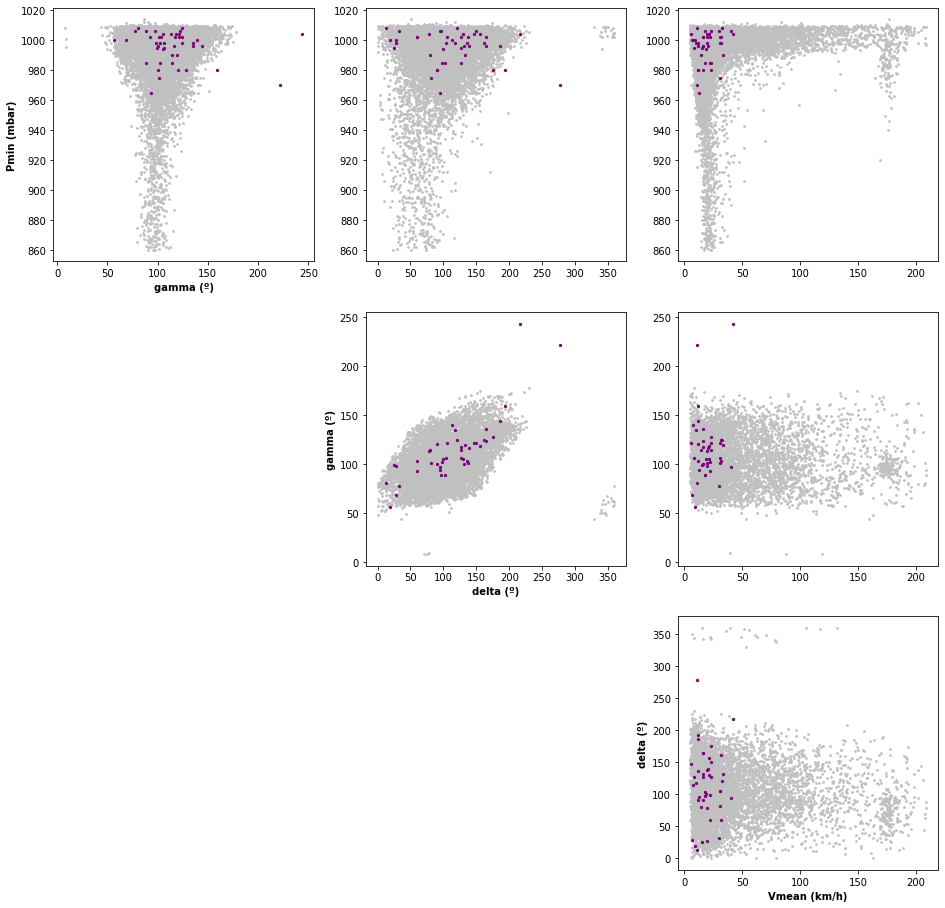

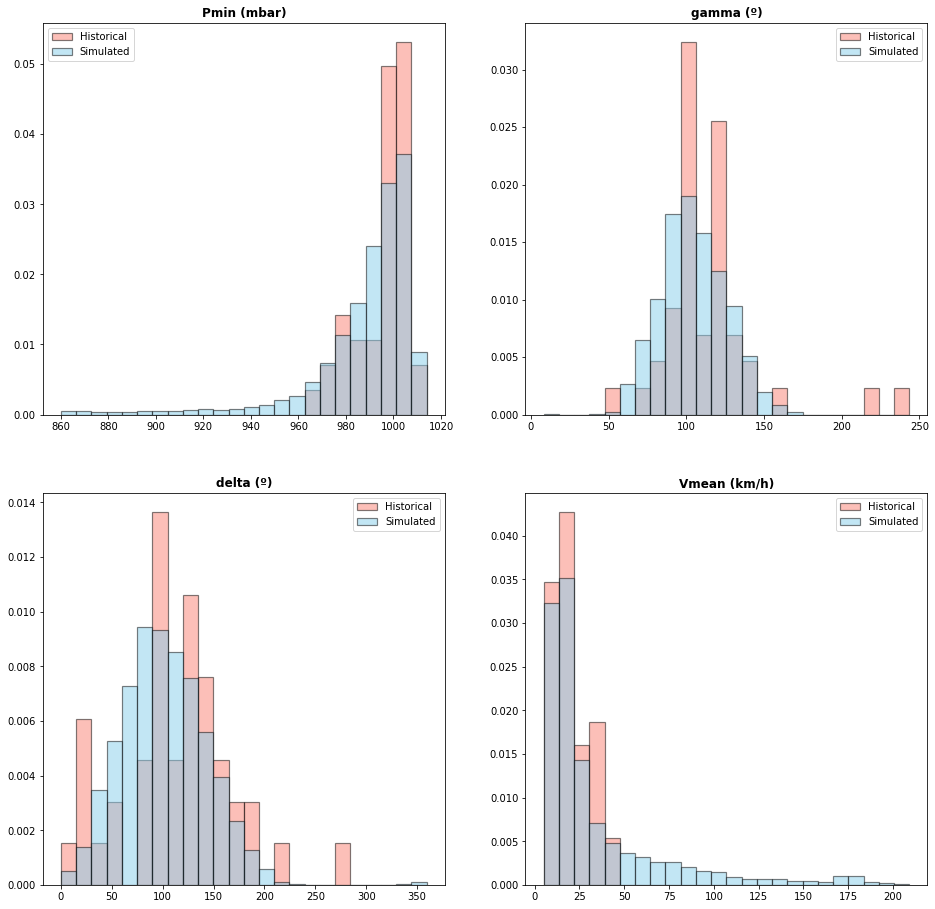

In [5]:
# Historical vs Nakajo Simulation parameters: 
_, TCs_r2_hist_params = db.Load_TCs_r2_hist()  # historical TCs parameters inside radius 2

# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params);

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params);



## Filter Nakajo tracks

In [6]:
#Minimum pressure
factor = 0.9
minP = factor * np.nanmin(TCs_r2_hist_params.pressure_min.values)   # (mbar)
#minP = minPmin   # (mbar)
print('Minimum Pmin: ',minP, 'mbar')

Minimum Pmin:  868.5 mbar


In [7]:
 #Maximum Vmean
factor = 1.3
maxV = factor * np.nanmax(TCs_r2_hist_params.velocity_mean.values)  # (km/h)
#maxV = maxVmean  # (km/h)
print('Maximum Vmean: ',np.round(maxV,1), 'km/h')

Maximum Vmean:  54.5 km/h


In [8]:
storms_filtered = []

for i,c in enumerate(TCs_r2_sim_params.storm.values):
    storm_i = TCs_r2_sim_params.sel(storm=c)
    
    if (storm_i.velocity_mean.values < maxV) & \
        (storm_i.pressure_min.values > minP):
        storms_filtered.append(c)
        
TCs_r2_sim_params_filtered = TCs_r2_sim_params.sel(storm = storms_filtered)
print('Numer of storms inside r2: ',TCs_r2_sim_params.storm.size)
print('Numer of storms inside r2 (filtered): ',TCs_r2_sim_params_filtered.storm.size, '\n')

db.Save_TCs_r2_sim_params(TCs_r2_sim_params_filtered)


Numer of storms inside r2:  9855
Numer of storms inside r2 (filtered):  8060 



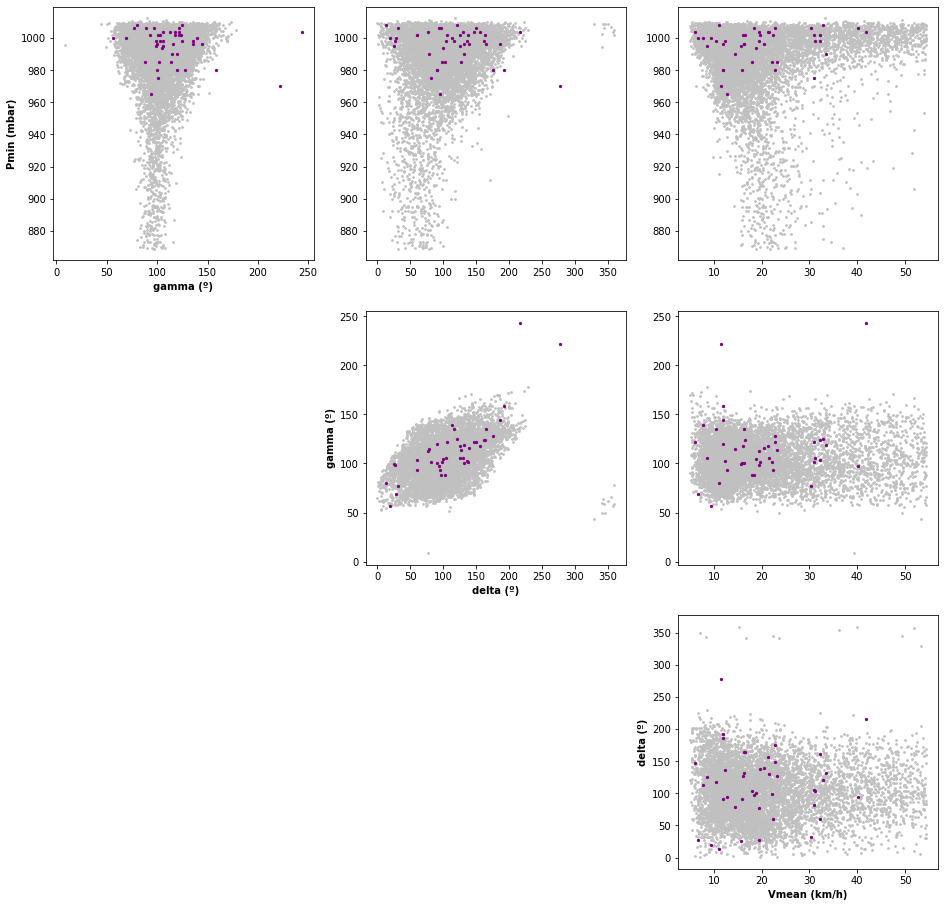

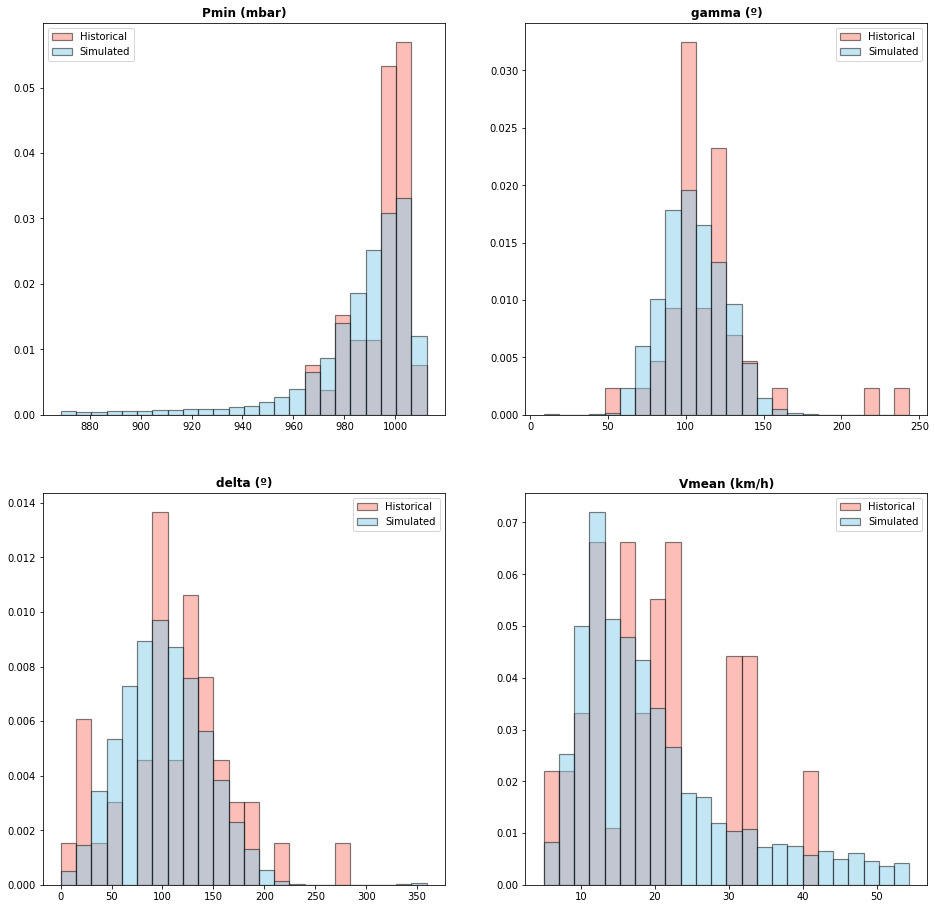

In [9]:
# scatter plot
Plot_TCs_Params_HISTvsSIM(TCs_r2_hist_params, TCs_r2_sim_params_filtered);

# histogram
Plot_TCs_Params_HISTvsSIM_histogram(TCs_r2_hist_params, TCs_r2_sim_params_filtered, 'Synthetic filtered');


## Simulated TCs - MaxDiss classification

In [10]:
# --------------------------------------
# MaxDiss classification

# get simulated parameters  
pmean_s = TCs_r2_sim_params_filtered.pressure_mean.values[:]
pmin_s  = TCs_r2_sim_params_filtered.pressure_min.values[:]
gamma_s = TCs_r2_sim_params_filtered.gamma.values[:]
delta_s = TCs_r2_sim_params_filtered.delta.values[:]
vmean_s = TCs_r2_sim_params_filtered.velocity_mean.values[:]

# subset, scalar and directional indexes
data_mda = np.column_stack((pmean_s, pmin_s, vmean_s, delta_s, gamma_s))
ix_scalar = [0,1,2]
ix_directional = [3,4]

# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)


# store MDA storms - parameters 
TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), centroids[:,0]),
        'pressure_min':(('storm'), centroids[:,1]),
        'velocity_mean':(('storm'), centroids[:,2]),
        'delta':(('storm'), centroids[:,3]),
        'gamma':(('storm'), centroids[:,4]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)
print(TCs_r2_MDA_params)

db.Save_TCs_r2_mda_params(TCs_r2_MDA_params)



MaxDiss dataset: 8060 --> 1000

   MDA centroids: 1000/1000

<xarray.Dataset>
Dimensions:        (storm: 1000)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    pressure_mean  (storm) float64 1.013e+03 870.8 1.009e+03 ... 974.2 995.2
    pressure_min   (storm) float64 1.012e+03 868.9 1.009e+03 ... 959.4 991.9
    velocity_mean  (storm) float64 33.17 18.76 53.36 8.618 ... 21.9 15.56 30.02
    delta          (storm) float64 117.3 32.29 329.1 229.3 ... 107.9 153.4 125.2
    gamma          (storm) float64 90.12 97.23 43.86 177.8 ... 116.6 135.9 102.2


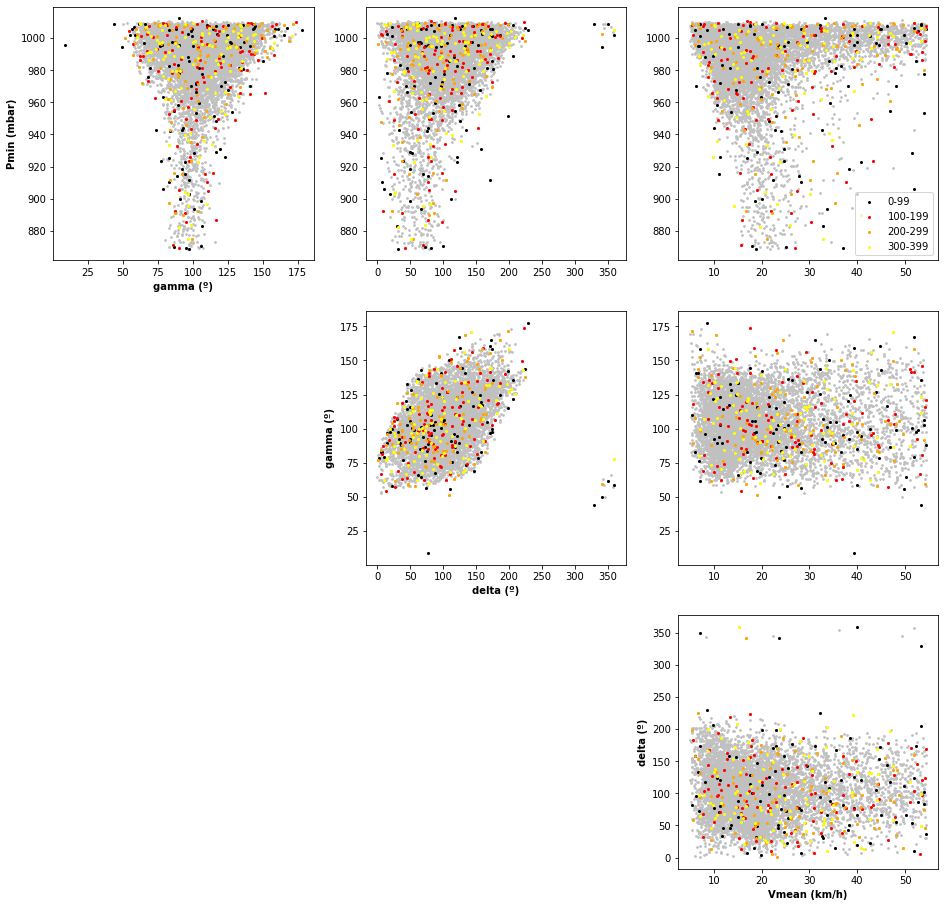

In [11]:
# Historical vs Simulated: scatter plot parameters
Plot_TCs_Params_MDAvsSIM(TCs_r2_MDA_params, TCs_r2_sim_params_filtered);

## Nakajo TCs (MDA centroids) Waves Simulation

Waves data is generated by numerically simulating selected storms. 

This methodology is not included inside teslakit python library.

This step needs to be done before continuing with notebook 07
